# 1 - Perkenalan

Name : Jason Rich Darmawan Onggo Putra

Batch : 016 RMT

Data set Overview : 

Objective :

# 2 - Import Libraries

In [1]:
# Data Loading
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from utils import num_imp, sel
import importlib
importlib.reload(num_imp)
importlib.reload(sel)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest

from imblearn.over_sampling import SMOTENC

# Model Definition
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# We will import tensorflow instead of per module
# This is because tensorflow do not give us docs if we use the from-import statement.
import tensorflow as tf

# Model Evaluation
import tensorflow_addons as tfa
from sklearn.metrics import classification_report

# Model Saving
import joblib

# 3 - Data Loading

- columns that are not good separator of the target: ['customerID']

In [2]:
# Load the data set
df = pd.read_csv("./WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preview the data set
with pd.option_context("display.max.columns", None):
    display(df.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> [Nominal data (from the Latin word “nomen” meaning “named” data), is data that names or labels variables without a numerical value. The simplest example would be “yes” or “no.” These are two categories, but there is no way to order them from highest to lowest or best to worst.](https://www.google.com/search?q=is+yes+and+no+ordinal&oq=is+yes+and+no+ordinal&aqs=edge..69i57j69i64.3078j0j1&sourceid=chrome&ie=UTF-8#:~:text=7%20Considerations%20for,com%20%E2%80%BA%20Blog)

- Some nominal columns have somewhat ordered category e.g column 'OnlineSecurity' have values 'Yes', 'No', 'No internet service'. However, the ordered category argument is weak, e.g when we ask Is 'No' better than 'No internet service'?. Therefore, we concludes it as nominal columns.

- nominal columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod']
- numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
- ordinal columns: ['Contract']

- target is nominal: 'Churn'

TODO
- [ ] Change nominal columns dtypes to 'category' with unordered categories.
  - double check 'SeniorCitizen'.
- [ ] Change 'Contract' dtypes to 'category' with ordered categories.
- [ ] Change 'TotalCharges' dtypess to 'float64' (dedicated for numerical columns).
- [ ] Change 'Churn' dtypes to 'category' with ordered categories.

In [3]:
# Check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# TotalCharges have ' ' value.
# df['TotalCharges'].astype('float64')

In [5]:
# Define columns
# Philosophy: Do not change anything until Data Preprocessing to simulate the real world.
nom_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod'
]
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
ord_cols = ['Contract']
target = 'Churn'

cat_cols = np.concatenate([nom_cols, ord_cols], axis=0)

# 4 - Exploratory Data Analysis (EDA)

- 'gender', 'Partner' ratio 1:1-ish
- 'SeniorCitizen' ratio 5:2 (No:Yes)

- 'PhoneService' ratio 0.7:6.3 (No:Yes)
  - 'MultipleLines' top is 'No'. The majority do not have multiple lines.

- 'InternetService' top is 'Fiber optic'.
  - 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' top is 'No'.

- 'PaperlessBilling' ratio 3:4 (No:Yes)
- 'PaymentMethod' top is 'Electronic check'.
- 'Contract' top is 'Month-to-month'

In [6]:
# Central Tendency categorical columns
df[cat_cols].astype('category').describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Contract
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,2,4,3
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Electronic check,Month-to-month
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,4171,2365,3875


- 'gender' is not a good separator of the target.
- 'SeniorCitizen': **senior citizen** is more likely to churn.
- 'Partner': customer with **no partner** is more likely to churn.
- 'Dependents': customer with **dependents** is more likely to churn.

- 'PhoneService', 'MultipleLines': is not a good separator of the target.

- 'InternetService': customer with **fiber optic** is more likely to churn.
  - 'OnlineSecurity': customer with **no online security** is more likely to churn.
  - 'OnlineBackup': customer with **no online backup** is more likely to churn.
  - 'DeviceProtection': customer with **no device protection** is morel likely to churn.
  - 'TechSupport': customer with **no tech support** is more likely to churn.

- Only 'StreamingTV' and 'StreamingMovies' (internet-related services that are offered to customer) that makes customer more likely to churn if they have internet service. It does make sense too. Why would a customer pay extra for TV and/or Movies that can be watched online nowadays.

  - 'StreamingTV': customer with **no internet service** is less likely to churn.
  - 'StreamingMovies': customer with **no internet service** is less likely to churn.

- 'PaperlessBilling': customer with **paperless billing** is more likely to churn.
- 'PaymentMethod': customer paying with **electronic check** is more likely to churn.
- 'Contract': customer **paying monthly** is more likely to churn.

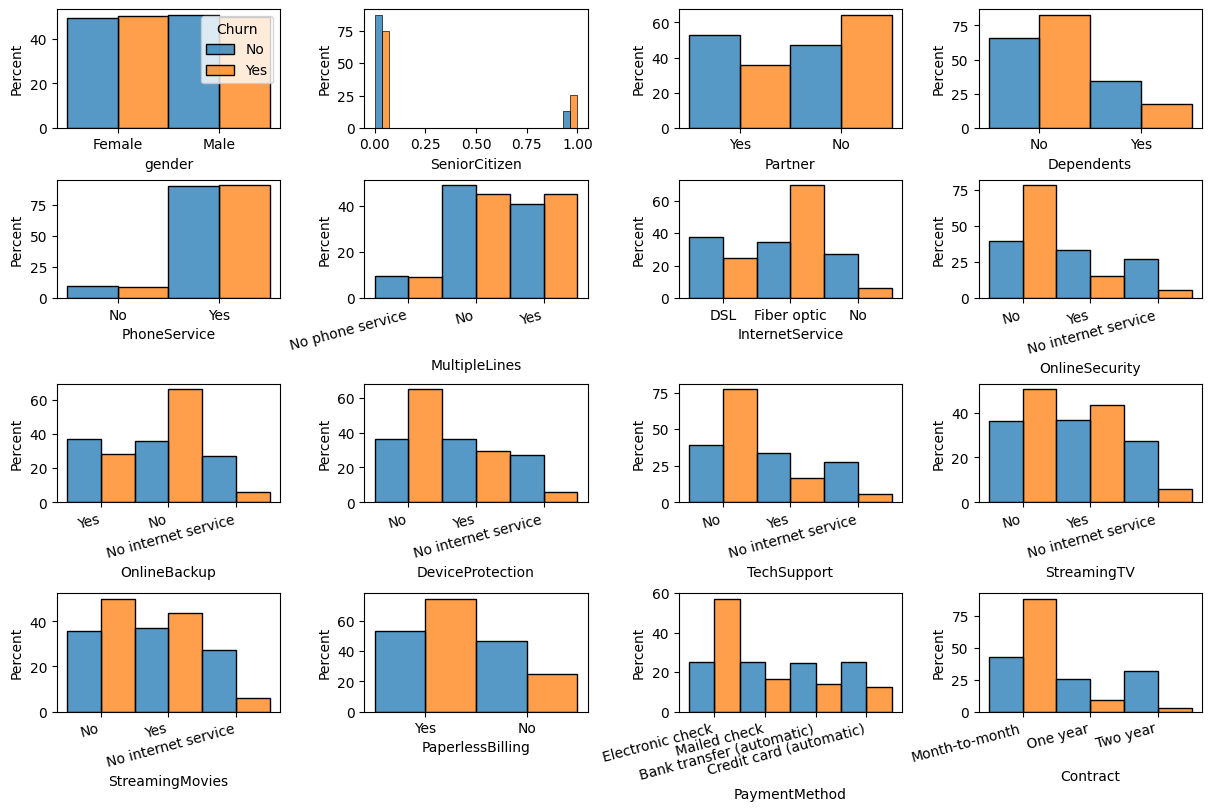

In [7]:
# histogram of nominal columns
# reference: https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
def isolate():
    fig, axes = plt.subplots(4,4, figsize=(12,8), layout='constrained')

    for column, ax in zip(cat_cols, axes.ravel()):
        sns.histplot(data=df, x=column, hue=target, multiple='dodge', 
            stat='percent', common_norm=False, 
        ax=ax)
        if column != 'gender':
            ax.get_legend().set_visible(False)
        if column in [
            'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod',
            'Contract'
        ]:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

isolate()

- 'TotalCharges' is moderately skewed to the right.

In [8]:
# Central Tendency numerical columns
def isolate():
    df_c = df.copy()
    # errors will be set to NaN
    df_c['TotalCharges'] = pd.to_numeric(df_c['TotalCharges'], errors='coerce')
    with pd.option_context("float_format", "{:,.2f}".format):
        display(df_c[num_cols].describe())
        display(df_c[num_cols].skew())

isolate()

,tenure,MonthlyCharges,TotalCharges
count,"7,043.00","7,043.00","7,032.00"
mean,32.37,64.76,"2,283.30"
std,24.56,30.09,"2,266.77"
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,"1,397.47"
75%,55.00,89.85,"3,794.74"
max,72.00,118.75,"8,684.80"


tenure            0.24
MonthlyCharges   -0.22
TotalCharges      0.96
dtype: float64

TODO
- [ ] Square Root Transformation numerical column 'TotalCharges'

[reference](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

TotalCharges Log Transformation -0.74
TotalCharges Square Root Transformation 0.31


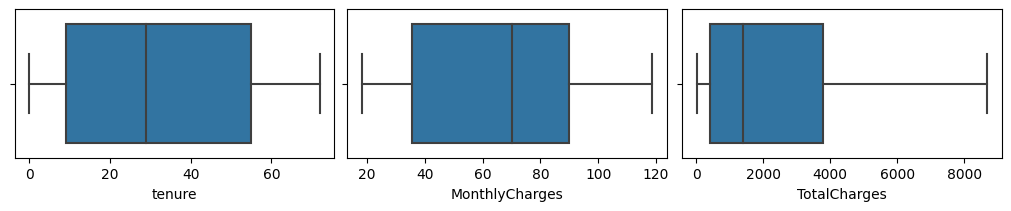

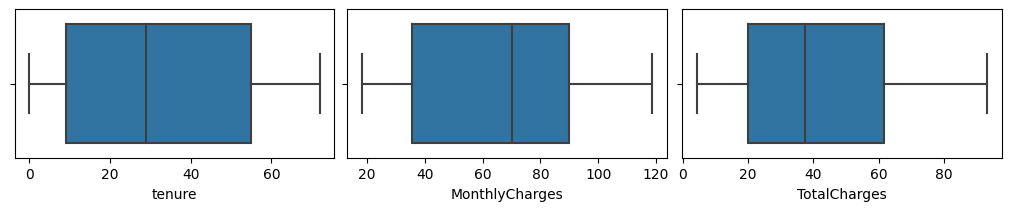

In [9]:
# boxplot of numerical columns
# Q3 + 1,5*IQR
def isolate():
    df_c = df.copy()
    df_c['TotalCharges'] = pd.to_numeric(df_c['TotalCharges'], errors='coerce')

    fig, axes = plt.subplots(1,3, layout="constrained", figsize=(10,2))
    for column, ax in zip(num_cols, axes.ravel()):
        sns.boxplot(data=df_c, x=column, ax=ax)

    print('TotalCharges Log Transformation %.2f' % np.log1p(df_c['TotalCharges']).skew())
    print('TotalCharges Square Root Transformation %.2f' % np.sqrt(df_c['TotalCharges']).skew())

    fig, axes = plt.subplots(1,3, layout="constrained", figsize=(10,2))
    for column, ax in zip(num_cols, axes.ravel()):
        if column != 'TotalCharges':
            sns.boxplot(data=df_c, x=column, ax=ax)
        else:
            sns.boxplot(data=np.sqrt(df_c[['TotalCharges']]), x=column, ax=ax)

isolate() 

- No 2-axis numerical features that is a good separator of the target.
  - 'tenure' < 20, 'MonthlyCharges' > 75 is more likely to churn.
  - 'TotalCharges' low, 'MonthlyCharges' high is more likely to churn. Therefore, it is recommended not to charge customer with high monthly charges in the beginning.

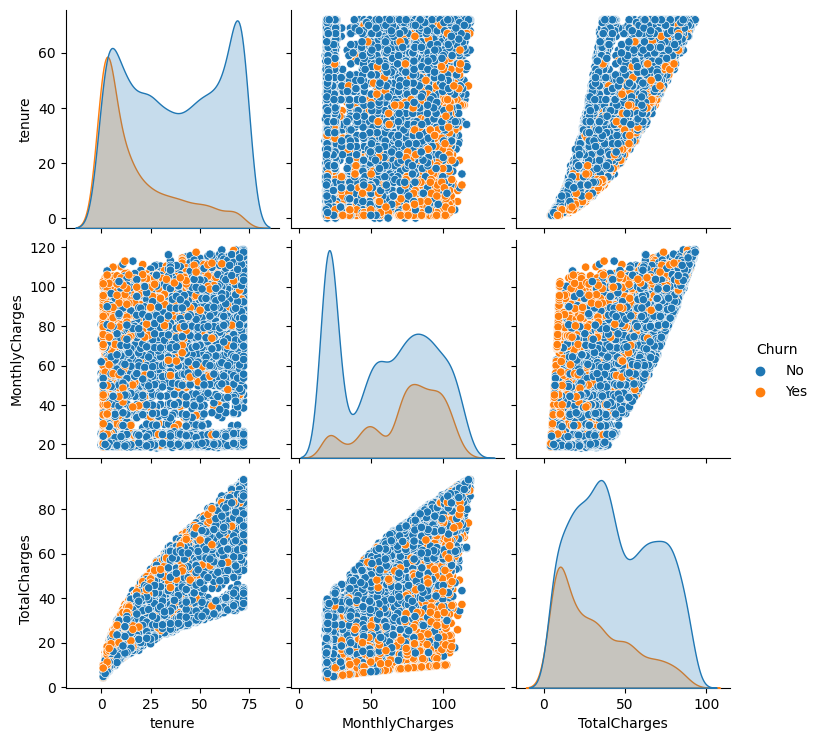

In [10]:
# 2-axis numerical features
def isolate():
    df_c = df.copy()
    df_c['TotalCharges'] = pd.to_numeric(df_c['TotalCharges'], errors='coerce')
    df_c['TotalCharges'] = np.sqrt(df_c['TotalCharges'])
    cols = np.concatenate([num_cols, [target]], axis=0)

    sns.pairplot(data=df_c[cols], hue=target)

isolate()

# 5 - Data Preprocessing

- Tensorflow pipeline can't impute missing values.
- Therefore, we will use `sklearn.pipeline.Pipeline` to impute missing values.
- Feature Scaling and Feature Encoding will be done with Tensorflow Pipeline.

- variable `df` is not modified.
- variable `df_a` only columns dtypes are modified. Handling missing values will be done by sklearn pipeline.
- variable `df_c` is local variable inside a Pipeline or `isolate()`.

In [11]:
# Prepare Inference Set
inf_set = df.groupby(by=target).sample(n=5, random_state=0)
inf_set

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
359,9833-TGFHX,Male,0,Yes,Yes,42,Yes,Yes,Fiber optic,Yes,...,No,No,Yes,Yes,One year,No,Electronic check,97.10,4016.75,No
2989,3308-MHOOC,Male,0,No,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.20,19.2,No
23,3638-WEABW,Female,0,Yes,No,58,Yes,Yes,DSL,No,...,No,Yes,No,No,Two year,Yes,Credit card (automatic),59.90,3505.1,No
4133,2208-UGTGR,Male,0,No,No,56,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,98.60,5581.05,No
190,7100-FQPRV,Male,0,Yes,Yes,43,Yes,Yes,DSL,Yes,...,No,Yes,No,Yes,One year,Yes,Credit card (automatic),71.90,3173.35,No
1822,4911-BANWH,Female,0,No,Yes,31,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),86.55,2697.4,Yes
1285,9134-CEQMF,Male,1,Yes,No,7,Yes,No,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.50,676.7,Yes
2563,5130-IEKQT,Male,1,No,No,25,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Mailed check,105.95,2655.25,Yes
5105,2995-UPRYS,Female,1,Yes,No,40,Yes,No,Fiber optic,No,...,No,Yes,Yes,Yes,One year,Yes,Credit card (automatic),99.20,4062.2,Yes
1029,4184-TJFAN,Female,1,Yes,Yes,3,Yes,No,Fiber optic,Yes,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,88.30,273.75,Yes


In [12]:
# Copy data set
df_a = df.copy()

# Drop Inference Set from df_a
df_a.drop(index=inf_set.index, inplace=True)

In [13]:
# Change nominal features dtypes to 'object'.
df_a[nom_cols] = df_a[nom_cols].astype('category')

In [14]:
# Change ordinal features dtypes to 'category'
Contract_cat = CategoricalDtype(categories=['Month-to-month', 'One year', 'Two year'])
df_a['Contract'] = df_a['Contract'].astype(Contract_cat)

In [15]:
# Change numerical features dtypes to number
# errors='coerce' invalid parsing will be set as NaN.
df_a['TotalCharges'] = pd.to_numeric(df_a['TotalCharges'], errors='coerce')

In [16]:
# Check missing values
df_a.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

TODO
- [ ] Impute 'TotalCharges' with 0 if the 'tenure' is 0. If not, impute with median.

In [17]:
# Check the characteristics of 'TotalCharges' with NaN value.
# We concludes that tenure 0 will have TotalCharges 0.
df_a.loc[(df_a['TotalCharges'].isna()) 
         | (df_a['tenure'] == 0), 
         ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,No
753,0,20.25,NaN,No
936,0,80.85,NaN,No
1082,0,25.75,NaN,No
1340,0,56.05,NaN,No
3331,0,19.85,NaN,No
3826,0,25.35,NaN,No
4380,0,20.00,NaN,No
5218,0,19.70,NaN,No
6670,0,73.35,NaN,No


In [18]:
# TotalCharges formula is not 'tenure' * 'MonthlyCharges'
# We will impute it with median.
df_a.loc[df_a['TotalCharges'] == (df_a['tenure'] * df_a['MonthlyCharges']), 
         ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

,tenure,MonthlyCharges,TotalCharges,Churn
0,1,29.85,29.85,No
20,1,39.65,39.65,Yes
22,1,20.15,20.15,Yes
27,1,30.20,30.20,Yes
33,1,20.20,20.20,No
...,...,...,...,...
6979,1,24.20,24.20,No
7010,1,74.45,74.45,Yes
7016,1,49.95,49.95,No
7018,1,70.65,70.65,Yes


## train_test_split

In [19]:
# Split data set to X and y
X = df_a.drop(labels=target, axis=1)
y = df_a[target]

In [20]:
# Check class imbalance
df_a['Churn'].value_counts()

No     5169
Yes    1864
Name: Churn, dtype: int64

In [21]:
# Split data set to train, validation and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=0)

## Sklearn Pipeline

In [22]:
# define numerical preprocessor
num_pipe = Pipeline(
    steps=[
        ('tc_imp', FunctionTransformer(
            func=num_imp.imp, kw_args={'features': num_cols}, 
            feature_names_out=num_imp.imp_out
        )),
        ('imputer', SimpleImputer(strategy='median')),
        ('sqrt', FunctionTransformer(
            func=num_imp.sqrt, kw_args={'features': num_cols}, 
            feature_names_out=num_imp.imp_out
        )),
        # although there is no outliers
        # based on mean + 3 * std or q3 + 1.5*IQR
        # 'TotalCharges' will increase overtime.
        # Fitted model within 1 year will always see outliers in 'TotalCharges'
        ('scaler', RobustScaler())
    ]
)

# sanity check
def isolate():
    num_pipe.fit(X=df_a[num_cols])

    df_c = df.copy()

    display("TotalCharges NaN with tenure 0", 
        num_pipe.transform(X=df_c.loc[df_c['TotalCharges'] == ' ', num_cols]))

    # NOTE: df_a has NaN values.
    print("median", df_a['TotalCharges'].median())

    df_c.loc[[0,1],'TotalCharges'] = np.nan
    display("TotalCharges NaN with tenure != 0", 
        num_pipe.transform(X=df_c.loc[[0,1], num_cols]))

    display("get_feature_names_out()", num_pipe.get_feature_names_out())

isolate()

nom_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # We will use OrdinalEncoder even for nominal features
        # This is based on beliefs that Decision Tree perform worse with 
        # one hot encoded features.
        # ANN is similar to Decision Tree.
        # It uses one feature to make decision, in this case determining the
        # weight and bias. Imagine a gender__Male feature full of zeros
        # because in a batch, everyone are Female.
        # The weight would be ~100 (close to the y-axis)
        # reference: https://kiwidamien.github.io/are-you-getting-burned-by-one-hot-encoding.html
        ('enc', OrdinalEncoder(
            categories=[
                df_a['gender'].cat.categories.tolist(),
                df_a['SeniorCitizen'].cat.categories.tolist(),
                df_a['Partner'].cat.categories.tolist(),
                df_a['Dependents'].cat.categories.tolist(),
                df_a['PhoneService'].cat.categories.tolist(),
                df_a['MultipleLines'].cat.categories.tolist(),
                df_a['InternetService'].cat.categories.tolist(),
                df_a['OnlineSecurity'].cat.categories.tolist(),
                df_a['OnlineBackup'].cat.categories.tolist(),
                df_a['DeviceProtection'].cat.categories.tolist(),
                df_a['TechSupport'].cat.categories.tolist(),
                df_a['StreamingTV'].cat.categories.tolist(),
                df_a['StreamingMovies'].cat.categories.tolist(),
                df_a['PaperlessBilling'].cat.categories.tolist(),
                df_a['PaymentMethod'].cat.categories.tolist()
            ],
            
            # OneHotEncoder parameter
            # multicollinearity test do not affect predictive power
            # we will not drop='first'
            # drop='first',
            # handle_unknown='ignore'
        ))
    ]
)

ord_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('enc', OrdinalEncoder(
            categories=[
                df_a['Contract'].cat.categories.tolist()
            ]
        ))
    ]
)

composer = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('nom', nom_pipe, nom_cols),
        ('ord', ord_pipe, ord_cols)
    ]
)

# sanity check
def isolate():
    composer.fit(X=df_a)

    df_c = pd.DataFrame(data=composer.transform(df_a), columns=composer.get_feature_names_out())

    display(df_c.head())

    display(df_c.info())

isolate()

'TotalCharges NaN with tenure 0'

array([[-0.63043478, -0.32658694, -0.89801226],
       [-0.63043478, -0.92088316, -0.89801226],
       [-0.63043478,  0.19411224, -0.89801226],
       [-0.63043478, -0.81968721, -0.89801226],
       [-0.63043478, -0.26218951, -0.89801226],
       [-0.63043478, -0.92824287, -0.89801226],
       [-0.63043478, -0.82704692, -0.89801226],
       [-0.63043478, -0.92548298, -0.89801226],
       [-0.63043478, -0.93100276, -0.89801226],
       [-0.63043478,  0.05611776, -0.89801226],
       [-0.63043478, -0.15455382, -0.89801226]])

median 1396.575


'TotalCharges NaN with tenure != 0'

array([[-0.60869565, -0.74425023,  0.        ],
       [ 0.10869565, -0.24563017,  0.        ]])

'get_feature_names_out()'

array(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

,num__tenure,num__MonthlyCharges,num__TotalCharges,nom__gender,nom__SeniorCitizen,nom__Partner,nom__Dependents,nom__PhoneService,nom__MultipleLines,nom__InternetService,nom__OnlineSecurity,nom__OnlineBackup,nom__DeviceProtection,nom__TechSupport,nom__StreamingTV,nom__StreamingMovies,nom__PaperlessBilling,nom__PaymentMethod,ord__Contract
0,-0.608696,-0.744250,-0.766521,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
1,0.108696,-0.245630,0.148145,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0
2,-0.586957,-0.302668,-0.647726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
3,0.347826,-0.515179,0.134561,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0
4,-0.586957,0.007360,-0.601635,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7033 entries, 0 to 7032
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num__tenure            7033 non-null   float64
 1   num__MonthlyCharges    7033 non-null   float64
 2   num__TotalCharges      7033 non-null   float64
 3   nom__gender            7033 non-null   float64
 4   nom__SeniorCitizen     7033 non-null   float64
 5   nom__Partner           7033 non-null   float64
 6   nom__Dependents        7033 non-null   float64
 7   nom__PhoneService      7033 non-null   float64
 8   nom__MultipleLines     7033 non-null   float64
 9   nom__InternetService   7033 non-null   float64
 10  nom__OnlineSecurity    7033 non-null   float64
 11  nom__OnlineBackup      7033 non-null   float64
 12  nom__DeviceProtection  7033 non-null   float64
 13  nom__TechSupport       7033 non-null   float64
 14  nom__StreamingTV       7033 non-null   float64
 15  nom_

None

## Feature Selection

We will do multicollinearity test before feature selection. However, we will not drop features that have collinearity. This is based on [our finding](https://github.com/kidfrom/hacktiv8-ftds-fase0/blob/master/x_fase1/week04_day06_libur/pm/pm2.ipynb) that features that are collinear do not reduce the predictive power.

We will do feature selection using `sklearn.feature_selection.mutual_info_classif`. This is based on beliefs that mutual information can be used both for continuous and discrete data. The continuous data will be transformed into bins, thus can be seen as discrete data.

Also, because [our finding](https://github.com/kidfrom/hacktiv8-ftds-fase0/blob/master/x_fase1/week04_day06_libur/pm/pm2.ipynb) shows that mutual information can detect non-linear relationship better than `f_classif`.

### Ask Instructor

- How to do multicollinearity test with one hot encoded nominal features?

  - Problem 1: `scipy.stats.chi2_contingency` uses cross tab instead of one hot encoded nominal features.

- As expected, 'tenure', 'MonthlyCharges' and 'TotalCharges' have correlation. However, EDA shows that 'TotalCharges' is not 'tenure' * 'MonthlyCharges'. Therefore, dropping the feature risk of losing information.

In [23]:
# Multicollinearity test
def isolate():
    X_train_final = composer.fit_transform(X=X_train)
    X_train_final_df = pd.DataFrame(
        data=X_train_final,
        columns=composer.get_feature_names_out()
    )
    cols = np.concatenate([
        ["num__" + num for num in composer.named_transformers_['num'].get_feature_names_out()],
        ["ord__" + ord for ord in composer.named_transformers_['ord'].get_feature_names_out()]
    ])
    display(X_train_final_df[cols].corr(method="kendall")
                                      .style
                                      .background_gradient(cmap="coolwarm"))

isolate()

,num__tenure,num__MonthlyCharges,num__TotalCharges,ord__Contract
num__tenure,1.000000,0.188039,0.729210,0.548257
num__MonthlyCharges,0.188039,1.000000,0.462810,-0.035539
num__TotalCharges,0.729210,0.462810,1.000000,0.362483
ord__Contract,0.548257,-0.035539,0.362483,1.000000


In [24]:
# Get discrete features bool
print([feature.startswith(("nom", "ord")) for feature in composer.get_feature_names_out()])

[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


- The mutual information result is similar to the EDA.

  We will select k=12. This is based on [our finding](https://github.com/kidfrom/hacktiv8-ftds-fase0/blob/master/x_fase1/week04_day06_libur/pm/pm2.ipynb) shows that `mi / np.max(mi)` ratio is between 0.32 (X1, which was hard coded to the y variable) to 1.0 (the feature with highest mutual information). 
  
  Therefore, we will only select feature near the ratio.

In [25]:
# Mutual information test
def isolate():
    composer.fit(X=X_train)
    X_train_final = composer.transform(X=X_train)
    y_train_final = y_train.map({'No': 0, 'Yes': 1})
    mi = mutual_info_classif(
        X=X_train_final, 
        y=y_train_final,
        discrete_features=[feature.startswith(("nom", "ord")) for feature in composer.get_feature_names_out()],
        random_state=0
    )
    df_c = pd.DataFrame()
    # df_c['mi'] = mi
    df_c['mi'] = mi / np.max(mi)
    df_c['feature'] = composer.get_feature_names_out()
    display(df_c.sort_values(by='mi', ascending=False)
                .reset_index()
                .style.background_gradient(cmap='coolwarm'))

    selector = SelectKBest(score_func=sel.sel_score, k=2)
    selector.fit(X=X_train_final, y=y_train_final)
    # sanity check
    print(selector.get_feature_names_out())

isolate()

,index,mi,feature
0,18,1.000000,ord__Contract
1,0,0.709058,num__tenure
2,13,0.636675,nom__TechSupport
3,10,0.625952,nom__OnlineSecurity
4,9,0.541096,nom__InternetService
5,11,0.464889,nom__OnlineBackup
6,2,0.464165,num__TotalCharges
7,17,0.441056,nom__PaymentMethod
8,12,0.422041,nom__DeviceProtection
9,1,0.416533,num__MonthlyCharges


['x0' 'x18']


## Preprocessor

In [26]:
# Define preprocessor
preprocessor = Pipeline(
    steps=[
        ('composer', composer),
        ('sel', SelectKBest(
            score_func=sel.sel_score,
            k=12,
        ))
    ]
)
preprocessor.fit(X=X_train, y=y_train)

# Define the scaled and encoded data set
X_train_final = preprocessor.transform(X=X_train)
y_train_final = y_train.map({'No': 0, 'Yes': 1})

X_val_final = preprocessor.transform(X=X_val)
y_val_final = y_val.map({'No': 0, 'Yes': 1})

X_test_final = preprocessor.transform(X=X_test)
y_test_final = y_test.map({'No': 0, 'Yes': 1})

## Tensorflow Pipeline

In [27]:
# shuffle(3).batch(36) because we got 12 features.
# We expected that each batch got
# e.g. a numerical feature with 3 unique points 
# (the highest point, the middle point, and the lowest point)
# so the algorithm can be confident, 
# that it have enough data to adjust the weight and bias
# prefetch(buffer_size=tf.data.AUTOTUNE) because we will use high epochs
train_pipe = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final)) \
                            .shuffle(3) \
                            .batch(36) \
                            .prefetch(buffer_size=tf.data.AUTOTUNE)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val_final, y_val_final)) \
                          .batch(36)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test_final,  y_test_final)) \
                           .batch(36)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-02 12:53:08.635421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 12:53:08.635519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 6 - Sequential API

## 6.1 - Model Definition

We are going to make 2 sequential model.
1. One with default parameter, just one hidden layer with 2 neuron (so it can make a plane in 3-axis), and activation function with sigmoid.

  We use activation function sigmoid because it is similar to the Logistic Regression. We assume that y < 0.5 is Class 0, y >= 0.5 is Class 1.

  If we use ReLu, the y = max(0,x). If we don't use activation function, the y = x

2. The second model is improved based on model evaluation of the default.

In [28]:
# Define sequential default

seq = tf.keras.Sequential(
    layers=[
        # 12 features
        tf.keras.Input(shape=(12,)),
        
        # 2 neuron can make a plane in a 3-axis.
        tf.keras.layers.Dense(units=2, use_bias=True, activation='relu'),
        
        # The expected output is No, Yes.
        # We believe that I know how ANN works with 2 output.
        # The model will choose the output with the highest value.
        # We don't know how ANN works with 1 output.
        # We imagine with 1 output that if the sum value is close to 1 then it's Yes, if not 0.
        # activation='sigmoid' because sigmoid is similar to 
        tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid'),
    ]
)

seq.compile(
    # I only know Stochastic Gradient Descent works.
    # SGD would randomly pick one batch for each step.
    optimizer=tf.keras.optimizers.SGD(),
    # The cross entropy formula is -ln(Probability of Class 0) + -ln(Probability of Class 1)
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            # average='macro' because the dataset is imbalanced
            # We don't want to give more weight to the class majority.
            # also, because it is convenient to plot.
            average='macro',
            # if we don't set the threshold e.g. to 0.5, 
            # the behavior will be weird
            threshold=0.3
        )
    ]
)

seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 26        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


Findings

- Increasing units from 2 to 4, decrease the number of epochs needed to achieve F1 Macro Score 0.62

In [29]:
# Define sequential improved

seq_imp = tf.keras.Sequential(
    layers=[
        tf.keras.Input(shape=(12,)),
        
        tf.keras.layers.Dense(
            # Increasing units from 2 to 4 increase the F1 Macro Score
            # from 0.6 to 0.62
            # Increasing units from 4 to 6 does not increase the F1 Macro Score.
            # Duly noted: we want simpler model and higher F1 Macro Score.
            # units=6 do not satisfy this requirement.
            # Therefore, we are using units=4
            units=4, use_bias=True,
            # reference: https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/
            kernel_initializer=tf.keras.initializers.HeNormal(seed=0)
        ),
        
        # We are not going to use Dropout
        # Dropout is meant to prevent overfitting.
        # The default model is not overfitted.
        # tf.keras.layers.Dropout(rate=0.1),
        
        # Apparently, if we randomly batch the data set.
        # The data distribution may change drastically.
        # reference: https://www.quora.com/Why-in-machine-learning-do-lots-of-people-want-to-convert-skewed-data-into-normal-distribution
        tf.keras.layers.BatchNormalization(),
        
        # ReLU function is y = max(0,x)
        # if the x is negative, the y will be always 0.
        tf.keras.layers.LeakyReLU(alpha=0.3),
        
        tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid')
    ]
)

seq_imp.compile(
    # We are not using Adam because we do not have vanishing gradient problem.
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            average='macro',
            threshold=0.3
        )
    ]
)

seq_imp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 52        
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73
Trainable params: 65
Non-trainable params: 8
_________________________________________________________________


## 6.2 - Model Training

In [30]:
# Train the sequential default

hist_seq = seq.fit(
    train_pipe,
    validation_data=val_pipe,
    epochs=10,
    # batch_size is set to None and will be ignored if we use pipe with .batch()
)

Epoch 1/10
 13/142 [=>............................] - ETA: 0s - loss: 0.8642 - f1_score: 0.4055  

2022-12-02 12:53:09.305461: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 12:53:09.305718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 6ms/step - loss: 0.6823 - f1_score: 0.4180 - val_loss: 0.5946 - val_f1_score: 0.4312
Epoch 2/10
  1/142 [..............................] - ETA: 0s - loss: 0.4502 - f1_score: 0.1739

2022-12-02 12:53:10.180355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 5ms/step - loss: 0.5747 - f1_score: 0.4445 - val_loss: 0.5611 - val_f1_score: 0.4615
Epoch 3/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5566 - f1_score: 0.4436 - val_loss: 0.5494 - val_f1_score: 0.4522
Epoch 4/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5468 - f1_score: 0.4487 - val_loss: 0.5406 - val_f1_score: 0.4615
Epoch 5/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5385 - f1_score: 0.4620 - val_loss: 0.5329 - val_f1_score: 0.4879
Epoch 6/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5311 - f1_score: 0.4770 - val_loss: 0.5255 - val_f1_score: 0.4963
Epoch 7/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5242 - f1_score: 0.4916 - val_loss: 0.5186 - val_f1_score: 0.5091
Epoch 8/10
142/142 [==============================] - 1s 5ms/step - loss: 0.5177 - f1_score: 0.5135 - val_loss: 0.5122 - val_f1_score: 0.5242
Epoch 9/10
142/14

- `tf.keras.callbacks.EarlyStopping` stops around 20 to 40 epochs. However, the F1 Macro Score is similar to 100 epochs.

In [31]:
# Train the sequential improved

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    # we believe the patience should be set to 3 
    # (before lowest slope, lowest slope, after lowest slope)
    # however, it stops too early and end up with lower F1 Macro Score.
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

hist_seq_imp = seq_imp.fit(
    train_pipe,
    validation_data=val_pipe,
    epochs=100,
    callbacks=[callback]
    # batch_size is set to None and will be ignored if we use pipe with .batch()
)

Epoch 1/100
  1/142 [..............................] - ETA: 51s - loss: 0.9342 - f1_score: 0.1622

2022-12-02 12:53:16.861343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 2s 8ms/step - loss: 0.7268 - f1_score: 0.4211 - val_loss: 0.5707 - val_f1_score: 0.5020
Epoch 2/100
  1/142 [..............................] - ETA: 0s - loss: 0.5757 - f1_score: 0.1818

2022-12-02 12:53:17.994497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 6ms/step - loss: 0.5696 - f1_score: 0.4945 - val_loss: 0.5114 - val_f1_score: 0.5532
Epoch 3/100
142/142 [==============================] - 1s 7ms/step - loss: 0.5168 - f1_score: 0.5483 - val_loss: 0.4904 - val_f1_score: 0.5574
Epoch 4/100
142/142 [==============================] - 1s 6ms/step - loss: 0.4938 - f1_score: 0.5639 - val_loss: 0.4777 - val_f1_score: 0.5710
Epoch 5/100
142/142 [==============================] - 1s 6ms/step - loss: 0.4806 - f1_score: 0.5811 - val_loss: 0.4695 - val_f1_score: 0.5841
Epoch 6/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4718 - f1_score: 0.5873 - val_loss: 0.4632 - val_f1_score: 0.5879
Epoch 7/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4659 - f1_score: 0.5897 - val_loss: 0.4582 - val_f1_score: 0.5975
Epoch 8/100
142/142 [==============================] - 1s 6ms/step - loss: 0.4615 - f1_score: 0.5967 - val_loss: 0.4541 - val_f1_score: 0.5921
Epoch 9/100

## 6.3 - Model Evaluation

- The loss function is -log(Probability of Class 0) + -log(Probability of Class 1)

  It is expected that the graph looks like an L.

  The graph shows us that if we increase the epochs parameter, the loss should diminish. Therefore, we will improve the model by increasing the number of epochs.

- The F1 Macro Score increased as the epochs number increased.
  
  We concludes that by increasing the epochs, we can increase the F1 Macro Score.

~~- (previous model with One-Hot Encoding) sufferd from the vanishing gradient problem.~~

  ~~We are not sure how to fix vanishing gradient problem. But, this happens because the step size (weight step size = weight * learning rate and bias step size = bias * learning rate) is getting close to 0.~~

val_f1_score max 0.54
val_loss min 0.50


<AxesSubplot: >

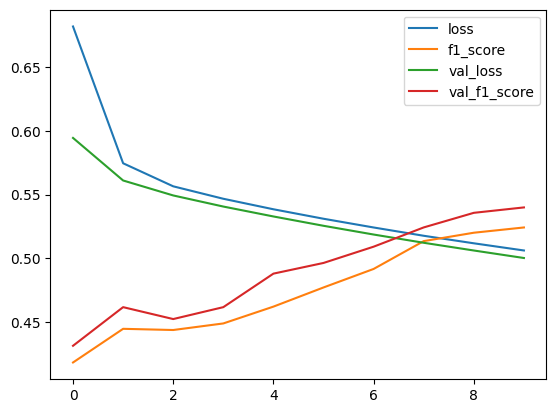

In [32]:
# Visualize the sequential default metrics
hist_seq_df = pd.DataFrame(hist_seq.history)

print("val_f1_score max %.2f" % (np.max(hist_seq_df['val_f1_score'])))
print("val_loss min %.2f" % (np.min(hist_seq_df['val_loss'])))

hist_seq_df.plot()

- The val_loss decrease and val_f1_score increase are insignificant after 15 epochs.

  This is not a vanishing gradient problem because before 15 epochs, the val_loss and val_f1_score did decrease.

  We concludes that this is the best F1 Macro Score for predicting Churn with this data set using the ANN algorithm.

val_f1_score max 0.61
val_loss min 0.43


<AxesSubplot: >

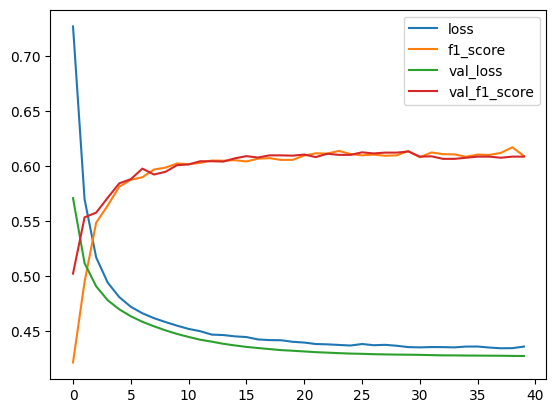

In [33]:
# Visualize the sequential improved metrics
hist_seq_imp_df = pd.DataFrame(data=hist_seq_imp.history)

print("val_f1_score max %.2f" % (np.max(hist_seq_imp_df['val_f1_score'])))
print("val_loss min %.2f" % (np.min(hist_seq_imp_df['val_loss'])))

hist_seq_imp_df.plot()

In [34]:
# Evaluating the model sequential improved
y_pred_seq_imp = seq_imp.predict(x=X_test_final)
y_pred_seq_imp = np.where(y_pred_seq_imp >= 0.30, 1, 0)

print(classification_report(y_test_final, y_pred_seq_imp))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       775
           1       0.53      0.80      0.64       280

    accuracy                           0.76      1055
   macro avg       0.72      0.77      0.73      1055
weighted avg       0.81      0.76      0.77      1055



2022-12-02 12:53:54.713814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


**The sequential improved model weakness are:**
1. The model tends to misclassify:
   1. a customer with month-to-month contract.
   2. a new customer / customer with tenure under 20 / customer with total charges below 4000.
   3. a customer with internet service:
      1. a customer with no tech support.
      2. a customer with no online security.
      3. a customer that is subscribing to the fiber optic or DSL service.
      4. a customer without online backup.
      4. a customer that is paying with Electronic check, Mail check, Credit Card (automatic)
      5. a customer with/out Device Protection.
      6. a customer with/out Streaming TV.
      7. a customer with/out Streaming Movies.
   4. a customer with monthly charges above 20.

**The sequential improved model strength are:**
1. The model can correctly classify:
   1. a customer with one year or two year contract.
   2. a old customer / customer with tenure above 40 / customer with total charges above 4000.
   3. a customer with tech support.
   4. a customer with online security.
   5. a customer with no internet service.
   6. a customer with online backup.
   7. a customer that is paying with Bank Transfer (automatic).
   8. a customer with monthly charges below 20.

We can assume that customer is more unpredictable if the contract is month-to-month, a new customer.

However, we can make the customer to be more predictable if a customer does not subscribe to our internet service, which means that customer subscribe to our phone service. Or, if a customer does subscribe to our internet service, a customer will be more predictable if a customer have tech support or online security or online backup. Regardless if a customer have internet service or not, a customer is more predictable if a customer have low monthly charges.

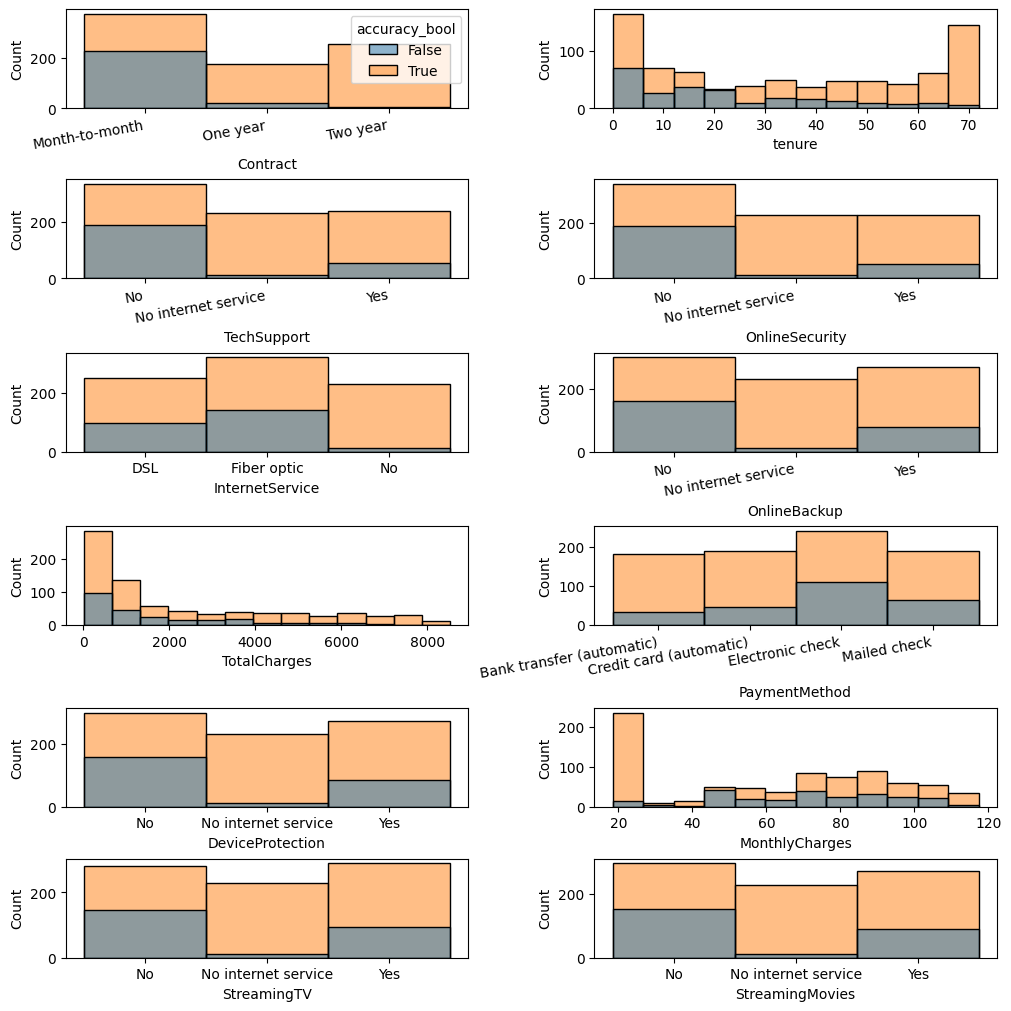

In [35]:
# Evaluating sequential improved weakness
def isolate():
    X_test_c = X_test.copy()
    X_test_c['accuracy_bool'] = y_test_final.values == y_pred_seq_imp.reshape(-1,)
    
    fig, axes = plt.subplots(6,2, figsize=(10,10), layout="constrained")
    
    for feature, ax in zip(
        [
            "Contract", "tenure", "TechSupport", "OnlineSecurity", "InternetService",
            "OnlineBackup", "TotalCharges", "PaymentMethod", "DeviceProtection",
            "MonthlyCharges", "StreamingTV", "StreamingMovies"
        ], 
        axes.ravel()
    ):
        sns.histplot(data=X_test_c, x=feature, hue="accuracy_bool", ax=ax)
        if feature != 'Contract':
            ax.get_legend().set_visible(False)
        if feature in [
            'Contract', 'TechSupport', 'OnlineSecurity', 'OnlineBackup',
            'PaymentMethod'
        ]:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
            
isolate()

## 6.4 - Model Saving

In [36]:
def isolate():
    # Preprocessor
    with open('./models/preprocessor.pkl', 'wb') as file_1:
        joblib.dump(preprocessor, file_1)
    
    # Freeze Model
    seq_imp.trainable = False
    
    seq_imp.save(filepath='./models/seq_imp.h5') 
    
isolate()

## 6.5 - Model Inference

In [37]:
# Load the sequential improved model

def isolate():
    global prep, model
    
    with open('./models/preprocessor.pkl', 'rb') as file_1:
        prep = joblib.load(file_1)
        
    model = tf.keras.models.load_model(filepath='./models/seq_imp.h5')
    
isolate()

In [38]:
# Predict with Inference Set

def isolate():
    X_inf_final = prep.transform(inf_set)
    
    y_inf_final = inf_set[target].map({'No': 0, 'Yes': 1})
    
    y_inf_pred_proba = model.predict(x=X_inf_final)
    
    y_inf_pred = np.where(y_inf_pred_proba >= 0.3, 1, 0)
    
    print("y_true", y_inf_final.values)
    print("y_pred", y_inf_pred.reshape(-1,))
    
    print(classification_report(y_true=y_inf_final, y_pred=y_inf_pred))
    
isolate()

1/1 [==============================] - 0s 45ms/step
y_true [0 0 0 0 0 1 1 1 1 1]
y_pred [0 0 0 1 0 1 1 1 0 1]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



2022-12-02 12:53:55.757928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# 7 - Functional API

## 7.1 - Model Definition

The goal is to do what sequential can't do. That is two layers in 1 step.

```
      / 2 neuron -> sum -> ELU        \
input                                   sum -> sigmoid activation function
      \ 2 neuron -> sum -> Leaky ReLU /
```

In [39]:
# Define functional default

def isolate():
    global model_fun
    
    input_layer = tf.keras.Input(shape=(12,))

    relu = tf.keras.layers.Dense(units=2, use_bias=True, activation='relu')(input_layer)
    elu = tf.keras.layers.Dense(
        units=2, use_bias=True, 
        activation=tf.keras.layers.LeakyReLU(alpha=0.3)
    )(input_layer)

    concat_layer = tf.keras.layers.concatenate([relu, elu])
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer)

    model_fun = tf.keras.Model(inputs=input_layer, outputs=output_layer)

isolate()

model_fun.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.3)
    ]
)

model_fun.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 2)            26          ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 2)            26          ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 4)            0           ['dense_4[0][0]',                
                                                                  'dense_5[0][0]']            

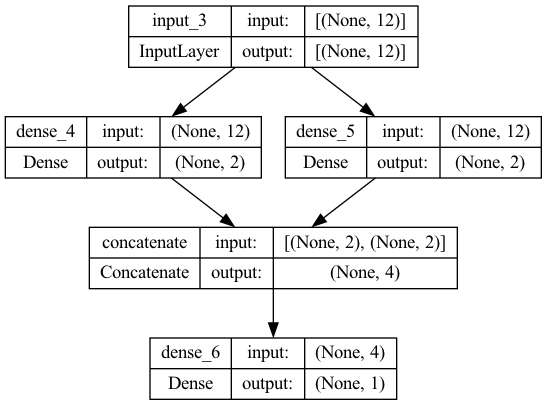

In [40]:
# Plot the functional default

tf.keras.utils.plot_model(model_fun, show_shapes=True)

In [41]:
# Define functional improved default

def isolate():
    global model_fun_imp

    input_layer = tf.keras.Input(shape=(12,))

    # We are going to add more neurons per layer
    # 2 neuron with ReLU can make a plane in 3-axis.
    # If we use 4 neurons, it can maybe a trapesium.
    # However, ReLU have problem if the value after weight + bias is negative
    # the y-axis will be always 0.
    # That's why we are going to use ELU and Leaky ReLU to fix dying ReLU.
    relu = tf.keras.layers.Dense(units=4, use_bias=True, activation='elu')(input_layer)
    elu = tf.keras.layers.Dense(
        units=4, use_bias=True, activation=tf.keras.layers.LeakyReLU(alpha=0.3)
    )(input_layer)

    concat_layer = tf.keras.layers.concatenate([relu, elu])
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(concat_layer)

    model_fun_imp = tf.keras.Model(inputs=input_layer, outputs=output_layer)

isolate()


model_fun_imp.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tfa.metrics.F1Score(num_classes=1, average='macro', threshold=0.3)
    ]
)

model_fun_imp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 4)            52          ['input_4[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 4)            52          ['input_4[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8)            0           ['dense_7[0][0]',                
                                                                  'dense_8[0][0]']          

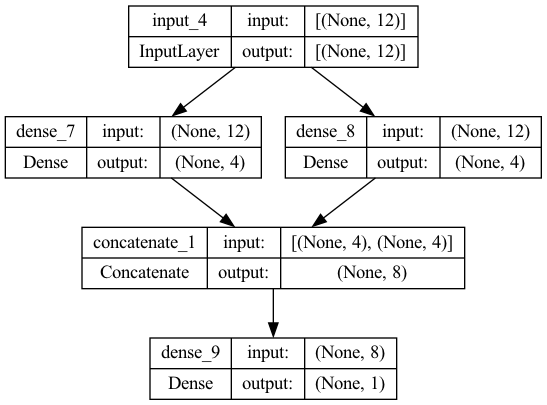

In [42]:
# Plot the functional default

tf.keras.utils.plot_model(model_fun_imp, show_shapes=True)

## 7.2 - Model Training

In [43]:
# Train the functional default

hist_fun = model_fun.fit(
    train_pipe,
    epochs=10,
    validation_data=val_pipe
)

Epoch 1/10
 10/142 [=>............................] - ETA: 0s - loss: 0.6741 - f1_score: 0.4000 

2022-12-02 12:53:56.823563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 7ms/step - loss: 0.6356 - f1_score: 0.4171 - val_loss: 0.5924 - val_f1_score: 0.4089
Epoch 2/10
  1/142 [..............................] - ETA: 0s - loss: 0.4736 - f1_score: 0.0909

2022-12-02 12:53:57.746125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 6ms/step - loss: 0.5595 - f1_score: 0.4750 - val_loss: 0.5503 - val_f1_score: 0.4898
Epoch 3/10
142/142 [==============================] - 1s 6ms/step - loss: 0.5317 - f1_score: 0.5074 - val_loss: 0.5307 - val_f1_score: 0.5090
Epoch 4/10
142/142 [==============================] - 1s 6ms/step - loss: 0.5170 - f1_score: 0.5282 - val_loss: 0.5185 - val_f1_score: 0.5235
Epoch 5/10
142/142 [==============================] - 1s 6ms/step - loss: 0.5076 - f1_score: 0.5412 - val_loss: 0.5092 - val_f1_score: 0.5295
Epoch 6/10
142/142 [==============================] - 1s 6ms/step - loss: 0.5004 - f1_score: 0.5502 - val_loss: 0.5013 - val_f1_score: 0.5461
Epoch 7/10
142/142 [==============================] - 1s 6ms/step - loss: 0.4943 - f1_score: 0.5585 - val_loss: 0.4943 - val_f1_score: 0.5464
Epoch 8/10
142/142 [==============================] - 1s 6ms/step - loss: 0.4890 - f1_score: 0.5634 - val_loss: 0.4882 - val_f1_score: 0.5502
Epoch 9/10
142/14

In [44]:
# Train the functional improved

hist_fun_imp = model_fun_imp.fit(
    train_pipe,
    validation_data=val_pipe,
    epochs=100,
    callbacks=[callback]
)

Epoch 1/100
  9/142 [>.............................] - ETA: 0s - loss: 1.0428 - f1_score: 0.4000 

2022-12-02 12:54:05.418445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 2s 9ms/step - loss: 0.5770 - f1_score: 0.5084 - val_loss: 0.4647 - val_f1_score: 0.5931
Epoch 2/100
  1/142 [..............................] - ETA: 0s - loss: 0.4060 - f1_score: 0.1333

2022-12-02 12:54:06.660500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 1s 7ms/step - loss: 0.4709 - f1_score: 0.5764 - val_loss: 0.4464 - val_f1_score: 0.6114
Epoch 3/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4571 - f1_score: 0.5898 - val_loss: 0.4382 - val_f1_score: 0.6175
Epoch 4/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4496 - f1_score: 0.6010 - val_loss: 0.4335 - val_f1_score: 0.6157
Epoch 5/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4448 - f1_score: 0.6077 - val_loss: 0.4304 - val_f1_score: 0.6099
Epoch 6/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4413 - f1_score: 0.6107 - val_loss: 0.4282 - val_f1_score: 0.6146
Epoch 7/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4388 - f1_score: 0.6147 - val_loss: 0.4266 - val_f1_score: 0.6192
Epoch 8/100
142/142 [==============================] - 1s 7ms/step - loss: 0.4367 - f1_score: 0.6149 - val_loss: 0.4255 - val_f1_score: 0.6214
Epoch 9/100

## 7.3 - Model Evaluation

The val_F1_score and val_loss line shows that by increasing the epochs, we can potetionally increase the val_F1_score and decrease the val_loss.

Therefore, we are going to increase the epochs and also add EarlyStopping mechanism in case the improvement is negligible after certain epochs.

val_f1_score max 0.55
val_loss min 0.48


<AxesSubplot: >

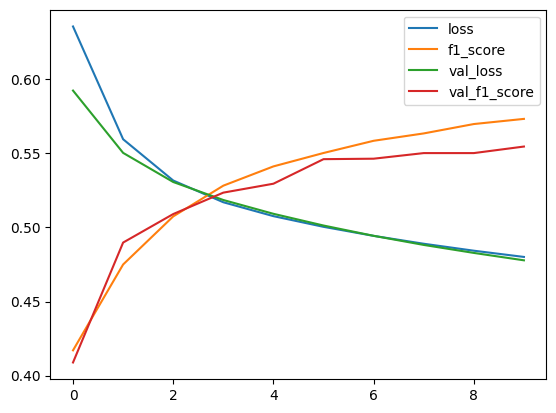

In [45]:
# Visualize the sequential default metrics
hist_fun_df = pd.DataFrame(hist_fun.history)

print("val_f1_score max %.2f" % (np.max(hist_fun_df['val_f1_score'])))
print("val_loss min %.2f" % (np.min(hist_fun_df['val_loss'])))

hist_fun_df.plot()

The functional improved metrics are better than the functional default metrics. 

The EarlyStopping mechanism helps us to save time as the val_loss and val_F1_Score shows that after epochs 40, it is not worthwhile to train more.

However, the functional improved metrics are not better than the sequential improved metrics (the val_F1_Score and val_loss are approximately equal). However, sequential improved only uses 4 neurons and Leaky ReLU, compared to functional improved which uses 8 neurons with ELU and Leaky ReLU.

Therefore, we are not going to deploy functional improved. Consequentlly, we will not visualize this model strength and weakness (we did evaluate [the sequential improved model](#63---model-evaluation) strengths and weaknesses).

val_f1_score max 0.64
val_loss min 0.42


<AxesSubplot: >

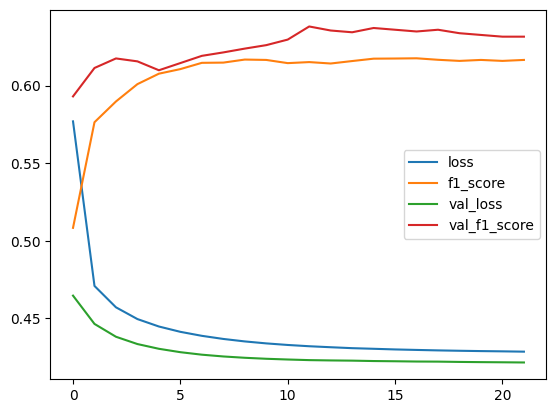

In [46]:
# Visualize the functional improved metrics
hist_fun_imp_df = pd.DataFrame(data=hist_fun_imp.history)

print("val_f1_score max %.2f" % (np.max(hist_fun_imp_df['val_f1_score'])))
print("val_loss min %.2f" % (np.min(hist_fun_imp_df['val_loss'])))

hist_fun_imp_df.plot()

In [47]:
# Evaluating the model sequential improved
y_pred_fun_imp = model_fun_imp.predict(x=X_test_final)
y_pred_fun_imp = np.where(y_pred_fun_imp >= 0.30, 1, 0)

print(classification_report(y_test_final, y_pred_fun_imp))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       775
           1       0.55      0.75      0.63       280

    accuracy                           0.77      1055
   macro avg       0.72      0.76      0.73      1055
weighted avg       0.80      0.77      0.78      1055



2022-12-02 12:54:28.207967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# 8 - Pengambilan Keputusan

We will deploy the sequential improved model because it have approximately equal val_f1_score with the functional improved model but squential improved model achieves it with less neurons.

We will inform management, to use this model for a specific customer segment which is more predictable according to the model:
1. A customer with one year or two year contract.
2. A old customer / customer with tenure above 40 / customer with total charges above 4000.
3. A customer without internet service.
4. A customer with internet service is unpredictable. 

   However, a customer with internet service and 1 related internet service will make the customer more predictable, e.g:
   1. A customer with tech support, or online security or online backup.

5. A customer that pays with Bank Transfer (automatic)
6. A customer with monthly charges below 20.

We will also inform management, not to use this model for a specific customer segment, which is less predictable according to the model:
1. A customer that is paying with Electronic check, Mail check, Credit Card (automatic)

Further Improvement:
1. We will improve the model witth `sklearn.model_selection.GridSearchCV`. 

   However, the number of neurons will be higher to achieve x% improvement which in turn, makes the computational cost higher as well.

   Therefore, we will also consider the `predict()` ms/step. Duly noted that `predict()` do the prediction in batch and not per 1 data. We will leave the `predict(batch_size= ?)` parameter for the algorithm to decide because we assume that Credit Card employee will want to use this model to predict from 1 to 100 customers at a time.

   [Tensorflow's GridSearchCV, keras.wrappers.scikit_learn](https://www.kaggle.com/code/snanilim/churn-deep-learning-vs-xgboost)